# Data Cleaning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /content/diabetes_data
!mkdir /content/diabetes_data/raw
!mkdir /content/diabetes_data/normalized
#!unzip /content/drive/MyDrive/diabetes.zip

mkdir: cannot create directory ‘/content/diabetes_data’: File exists
mkdir: cannot create directory ‘/content/diabetes_data/raw’: File exists
mkdir: cannot create directory ‘/content/diabetes_data/normalized’: File exists
Archive:  /content/drive/MyDrive/diabetes.zip
  inflating: diabetes.csv            


In [ ]:
!cp diabetes.csv /content/diabetes_data/raw

In [ ]:
import numpy as np
import pandas as pds
from sklearn.linear_model import LogisticRegression
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
import scipy.stats
import tensorflow
import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
# Setting seed for reproducability
np.random.seed(0)

AttributeError: ignored

In [ ]:
'''
Read raw data
@file             data file path
@pds_data         pandas dataframe
@data             np array
'''

file = '/content/diabetes.csv'
pds_data = pds.read_csv(file)
data = pds_data.to_numpy()
pds_data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
'''
normalize raw data
baseline is mean value
@mormalized_diabetes   normalized raw data in np array
'''

normalized_data = np.copy(data)

num_value = np.count_nonzero(data, axis=0)
mean = np.sum(data, axis=0) / num_value

normalized_data[:, :8] = normalized_data[:, :8] / mean[:8]
print("normalized_diabetes:", normalized_data.shape)

# recommend save to a temp file if you want to adjust the value
np.savetxt("diabetes_data/normalized/normalized_diabetes.csv", normalized_data, delimiter=',')

normalized_diabetes: (768, 9)


In [ ]:
'''
seperate data
Note that empty data is filled with 0 in the dataset
index 0 is pregnancies, 0 is not considered as empty data
there is no unlabeled data
@complete_data        complete raw data in np array
@incomplete_data      in complete raw data in np array
'''

def seperate(dataset):
  complete = []
  incomplete = []
  for index in range(0, dataset.shape[0]):
    if np.all(dataset[index][1:len(dataset[index]) - 1]):
      # index 0 is pregnancies
      # 0 not considered as empty data
      if len(complete) == 0:
        complete = dataset[index]
      else:
        complete = np.vstack((complete, dataset[index]))
    else:
      if len(incomplete) == 0:
        incomplete = dataset[index]
      else:
        incomplete = np.vstack((incomplete, dataset[index]))
  return complete, incomplete


# seperate raw data
complete_data, incomplete_data = seperate(data)
print("complete_data:", complete_data.shape)
print("incomplete_data:", incomplete_data.shape)

# recommend save to a temp file if you want to adjust the original value
np.savetxt("diabetes_data/raw/complete_data.csv", complete_data, delimiter=',')
np.savetxt("diabetes_data/raw/incomplete_data.csv", incomplete_data, delimiter=',')

# seperate normalized data
normalized_complete_data, normalized_incomplete_data = seperate(normalized_data)
print("normalized_complete_data:", normalized_complete_data.shape)
print("normalized_incomplete_data:", normalized_incomplete_data.shape)

# recommend save to a temp file if you want to adjust the original value
np.savetxt("diabetes_data/normalized/normalized_complete_data.csv", normalized_complete_data, delimiter=',')
np.savetxt("diabetes_data/normalized/normalized_incomplete_data.csv", normalized_incomplete_data, delimiter=',')

complete_data: (392, 9)
incomplete_data: (376, 9)
normalized_complete_data: (392, 9)
normalized_incomplete_data: (376, 9)


In [ ]:
'''
use overall mean value to complete data
@overall_mean_completed   overall mean completed data in np array
'''
#this cell is a reference, but variables and files generated from this are not used at any point

def overall_mean_complete(dataset, incomplete):
  num_value = np.count_nonzero(dataset, axis=0)
  mean = np.sum(dataset, axis=0) / num_value

  feature_array = np.transpose(np.copy(incomplete))
  for index in range(1, 8): #exclude pregnancies and class pabel
    feature_array[index] = np.where(feature_array[index] == 0, mean[index], feature_array[index])
  overall_mean_completed = np.transpose(feature_array)
  return overall_mean_completed

# data saved in overall_mean_completed.csv without the original completed data
overall_mean_completed = overall_mean_complete(data, incomplete_data)
np.savetxt("diabetes_data/raw/overall_mean_completed.csv", overall_mean_completed, delimiter=',')

# normalized version
normalized_overall_mean_completed = overall_mean_complete(normalized_data, normalized_incomplete_data)
np.savetxt("diabetes_data/normalized/normalized_overall_mean_completed.csv", normalized_overall_mean_completed, delimiter=',')

In [ ]:
'''
use mean value of the same class to complete data
@class_mean_completed       class mean completed data in np array
'''
def class_mean_complete(dataset, incomplete):
  labels = np.transpose(dataset)[-1]
  class0 = np.copy(dataset[np.argwhere(labels == 0).flatten()])
  num_value = np.count_nonzero(class0, axis=0)
  num_value[-1] = 1 #fix zero_division error when dealing with class label 0
  mean = np.sum(class0, axis=0) / num_value
  labels = np.transpose(incomplete)[-1]
  class0 = np.copy(incomplete[np.argwhere(labels == 0).flatten()])
  feature_array = np.transpose(class0)
  for index in range(1, 8): #exclude pregnancies and class pabel
    feature_array[index] = np.where(feature_array[index] == 0, mean[index], feature_array[index])
  class_mean_completed = np.transpose(feature_array)

  labels = np.transpose(dataset)[-1]
  class1 = np.copy(dataset[np.argwhere(labels == 1).flatten()])
  num_value = np.count_nonzero(class1, axis=0)
  mean = np.sum(class1, axis=0) / num_value
  labels = np.transpose(incomplete)[-1]
  class1 = np.copy(incomplete[np.argwhere(labels == 1).flatten()])
  feature_array = np.transpose(class1)
  for index in range(1, 8): #exclude pregnancies and class pabel
    feature_array[index] = np.where(feature_array[index] == 0, mean[index], feature_array[index])
  class_mean_completed = np.vstack((class_mean_completed, np.transpose(feature_array)))
  return class_mean_completed

#data saved in class_mean_completed.csv without the original completed data
class_mean_completed = class_mean_complete(data, incomplete_data)
np.savetxt("diabetes_data/raw/class_mean_completed.csv", class_mean_completed, delimiter=',')
#normalized version
normalized_class_mean_completed = class_mean_complete(normalized_data, normalized_incomplete_data)
np.savetxt("diabetes_data/normalized/normalized_class_mean_completed.csv", normalized_class_mean_completed, delimiter=',')


## Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

f1 score - : 0.447
recall - : 0.000
accuracy - : 0.597
f1 score - : 0.504
recall - : 0.081
accuracy - : 0.610
f1 score - : 0.572
recall - : 0.226
accuracy - : 0.623
f1 score - : 0.740
recall - : 0.581
accuracy - : 0.747
f1 score - : 0.754
recall - : 0.597
accuracy - : 0.760
f1 score - : 0.754
recall - : 0.597
accuracy - : 0.760


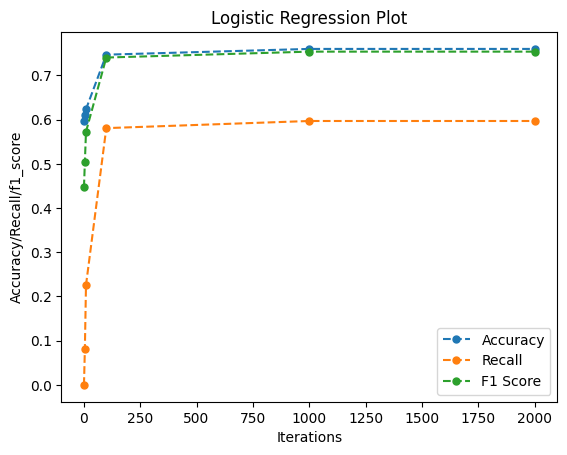

In [ ]:
# Start with complete raw data
# Includes some incomplete data (some patients have 0 on features they are not supposed to)
max_iter=[1, 5, 10, 100, 1000, 2000]
np.random.shuffle(data)
features = data[:, :8]
classification = data[:, 8]
X_train, X_test, y_train, y_test = train_test_split(features, classification, test_size=0.2, random_state=42)
accuracies = []
recalls = []
f1_scores = []
for iter in max_iter:
  raw_model = LogisticRegression(max_iter=iter)
  raw_model.fit(X_train, y_train.flatten())
  logisticregacc = raw_model.score(X_test, y_test)
  y_pred = raw_model.predict(X_test)
  recall = recall_score(y_test, y_pred)
  score = f1_score(y_test, y_pred, average='weighted')
  print(f'f1 score - : {score:.3f}')
  print(f'recall - : {recall:.3f}')
  print(f'accuracy - : {logisticregacc:.3f}')
  accuracies.append(logisticregacc)
  recalls.append(recall)
  f1_scores.append(score)


plt.plot(max_iter, accuracies, 'o', label='Accuracy', markersize=5, linestyle="--")
plt.plot(max_iter, recalls, 'o', label='Recall', markersize=5, linestyle="--")
plt.plot(max_iter, f1_scores, 'o', label='F1 Score', markersize=5, linestyle="--")
plt.title("Logistic Regression Plot")
plt.xlabel("Iterations")
plt.ylabel("Accuracy/Recall/f1_score")
plt.legend()
plt.show()


#Fine tuning the model
- The logistic regression fails to converge so we can try normalizing the data


f1 score - : 0.744
recall - : 0.500
accuracy - : 0.753
f1 score - : 0.744
recall - : 0.500
accuracy - : 0.753
f1 score - : 0.744
recall - : 0.500
accuracy - : 0.753


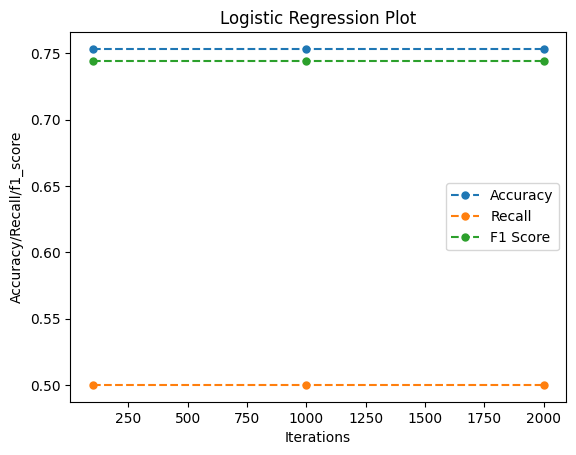

In [ ]:
max_iter=[100, 1000, 2000]
np.random.shuffle(normalized_data)
features = normalized_data[:, :8]
classification = normalized_data[:, 8]
X_train, X_test, y_train, y_test = train_test_split(features, classification, test_size=0.2, random_state=42)
accuracies = []
recalls = []
f1_scores = []
for iter in max_iter:
  raw_model = LogisticRegression(max_iter=iter)
  raw_model.fit(X_train, y_train.flatten())
  logisticregacc = raw_model.score(X_test, y_test)
  y_pred = raw_model.predict(X_test)
  recall = recall_score(y_test, y_pred)
  score = f1_score(y_test, y_pred, average='weighted')
  print(f'f1 score - : {score:.3f}')
  print(f'recall - : {recall:.3f}')
  print(f'accuracy - : {logisticregacc:.3f}')
  accuracies.append(logisticregacc)
  recalls.append(recall)
  f1_scores.append(score)

plt.plot(max_iter, accuracies, 'o', label='Accuracy', markersize=5, linestyle="--")
plt.plot(max_iter, recalls, 'o', label='Recall', markersize=5, linestyle="--")
plt.plot(max_iter, f1_scores, 'o', label='F1 Score', markersize=5, linestyle="--")
plt.title("Logistic Regression Plot")
plt.xlabel("Iterations")
plt.ylabel("Accuracy/Recall/f1_score")
plt.legend()
plt.show()

By Normalizing the data we can get the logistic regression to converge <br>
However the accuracy stays the same. We can try fine tuning it further by
<br>
trying other optimization algorithms

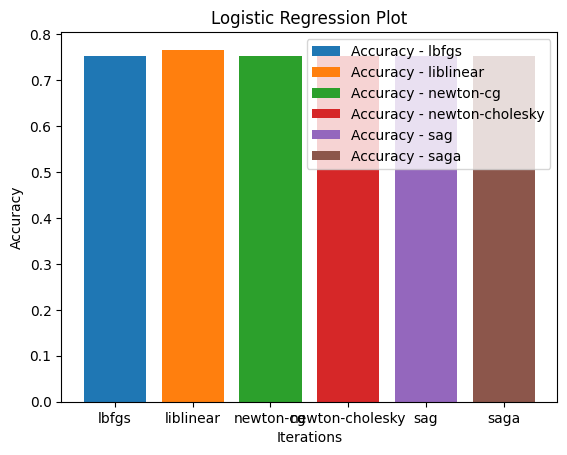

In [ ]:
max_iter=[1000]
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
#Note: Scikit defaults to lbfgs
for solver in solvers:
  accuracies = []
  recalls = []
  f1_scores = []
  # print("curr solver:", solver)
  for iter in max_iter:
    raw_model = LogisticRegression(solver=solver, max_iter=iter)
    raw_model.fit(X_train, y_train.flatten())
    logisticregacc = raw_model.score(X_test, y_test)
    y_pred = raw_model.predict(X_test)
    recall = recall_score(y_test, y_pred)
    score = f1_score(y_test, y_pred, average='weighted')
    # print(f'f1 score - : {score:.3f}')
    # print(f'recall - : {recall:.3f}')
    # print(f'accuracy - : {logisticregacc:.3f}')
    accuracies.append(logisticregacc)
    recalls.append(recall)
    f1_scores.append(score)
  plt.bar(solver, max(accuracies), label='Accuracy - ' + solver)
  # plt.plot(max_iter, recalls, 'o', label='Recall - ' + solver, markersize=5, linestyle="--")
  # plt.plot(max_iter, f1_scores, 'o', label='F1 Score - ' + solver, markersize=5, linestyle="--")

plt.title("Logistic Regression Plot")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


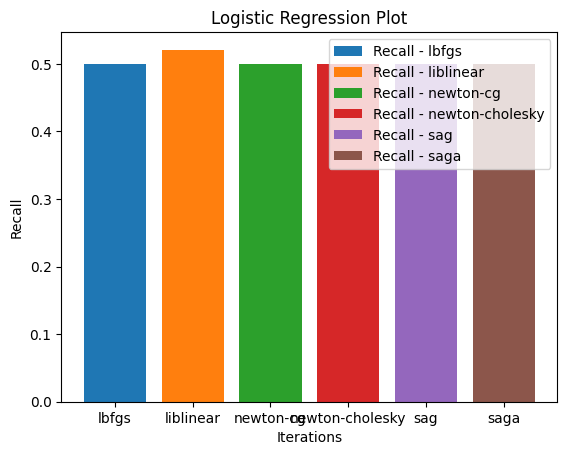

In [ ]:
max_iter=[1000]
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
#Note: Scikit defaults to lbfgs
for solver in solvers:
  accuracies = []
  recalls = []
  f1_scores = []
  # print("curr solver:", solver)
  for iter in max_iter:
    raw_model = LogisticRegression(solver=solver, max_iter=iter)
    raw_model.fit(X_train, y_train.flatten())
    logisticregacc = raw_model.score(X_test, y_test)
    y_pred = raw_model.predict(X_test)
    recall = recall_score(y_test, y_pred)
    score = f1_score(y_test, y_pred, average='weighted')
    # print(f'f1 score - : {score:.3f}')
    # print(f'recall - : {recall:.3f}')
    # print(f'accuracy - : {logisticregacc:.3f}')
    accuracies.append(logisticregacc)
    recalls.append(recall)
    f1_scores.append(score)
  #plt.plot(max_iter, accuracies, 'o', label='Accuracy - ' + solver, markersize=5, linestyle="--")
  plt.bar(solver, max(recalls), label='Recall - ' + solver)
  # plt.plot(max_iter, f1_scores, 'o', label='F1 Score - ' + solver, markersize=5, linestyle="--")

plt.title("Logistic Regression Plot")
plt.xlabel("Iterations")
plt.ylabel("Recall")
plt.legend()
plt.show()


From the graphs, we can see that different optimizers do not have a signficiant effect on the accuracty of the classifier
<br>
<br>
Instead of focusing on the model implementation, let us try using a more completed version of the data (as explained in the pre-processing part of the colab)

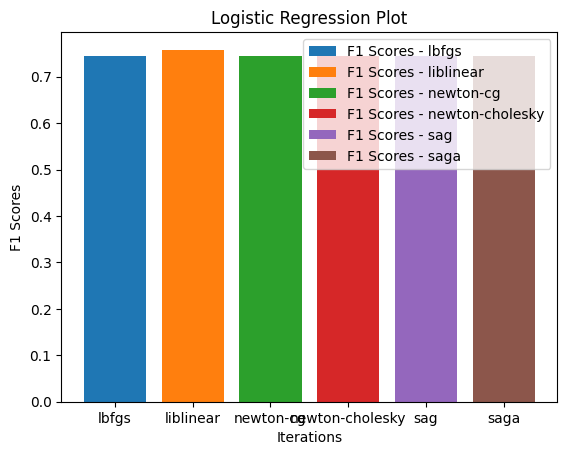

In [ ]:
max_iter=[1000]
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
#Note: Scikit defaults to lbfgs
for solver in solvers:
  accuracies = []
  recalls = []
  f1_scores = []
  # print("curr solver:", solver)
  for iter in max_iter:
    raw_model = LogisticRegression(solver=solver, max_iter=iter)
    raw_model.fit(X_train, y_train.flatten())
    logisticregacc = raw_model.score(X_test, y_test)
    y_pred = raw_model.predict(X_test)
    recall = recall_score(y_test, y_pred)
    score = f1_score(y_test, y_pred, average='weighted')
    # print(f'f1 score - : {score:.3f}')
    # print(f'recall - : {recall:.3f}')
    # print(f'accuracy - : {logisticregacc:.3f}')
    accuracies.append(logisticregacc)
    recalls.append(recall)
    f1_scores.append(score)
  plt.bar(solver, max(f1_scores), label='F1 Scores - ' + solver)
  # plt.plot(max_iter, accuracies, 'o', label='Accuracy - ' + solver, markersize=5, linestyle="--")
  # # plt.plot(max_iter, recalls, 'o', label='Recall - ' + solver, markersize=5, linestyle="--")

  #plt.plot(max_iter, f1_scores, 'o', label='F1 Score - ' + solver, markersize=5, linestyle="--")

plt.title("Logistic Regression Plot")
plt.xlabel("Iterations")
plt.ylabel("F1 Scores")
plt.legend()
plt.show()


In [ ]:
# Train model using completed data and compare accuracy
completedData = np.loadtxt('./diabetes_data/raw/complete_data.csv', delimiter=',')
classMeanData = np.loadtxt('./diabetes_data/raw/class_mean_completed.csv', delimiter=',')
finalData = np.vstack((completedData, classMeanData))
np.random.shuffle(finalData)
features2 = finalData[:, :8]
classification2 = finalData[:, 8]
X_train, X_test, y_train, y_test = train_test_split(features2, classification2, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


f1 score - : 0.779
recall - : 0.646
accuracy - : 0.779
f1 score - : 0.782
recall - : 0.604
accuracy - : 0.786
f1 score - : 0.782
recall - : 0.604
accuracy - : 0.786


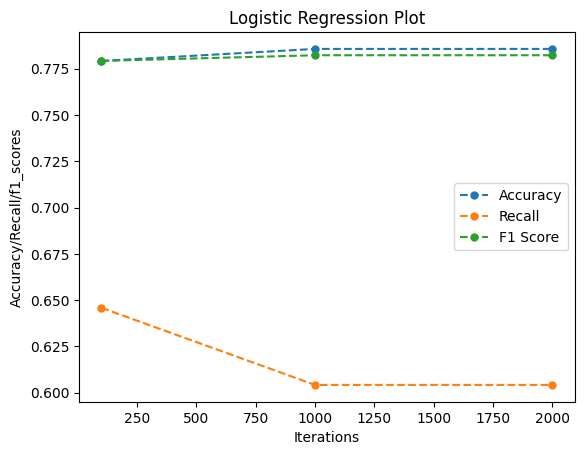

In [ ]:
accuracies = []
recalls = []
f1_scores = []
max_iter = [100, 1000, 2000]
for iter in max_iter:
  model = LogisticRegression(max_iter=iter)
  model.fit(X_train, y_train.flatten())
  logisticregacc = model.score(X_test, y_test)
  y_pred = model.predict(X_test)
  recall = recall_score(y_test, y_pred)
  score = f1_score(y_test, y_pred, average='weighted')
  print(f'f1 score - : {score:.3f}')
  print(f'recall - : {recall:.3f}')
  print(f'accuracy - : {logisticregacc:.3f}')
  accuracies.append(logisticregacc)
  recalls.append(recall)
  f1_scores.append(score)

plt.plot(max_iter, accuracies, 'o', label='Accuracy', markersize=5, linestyle="--")
plt.plot(max_iter, recalls, 'o', label='Recall', markersize=5, linestyle="--")
plt.plot(max_iter, f1_scores, 'o', label='F1 Score', markersize=5, linestyle="--")
plt.title("Logistic Regression Plot")
plt.xlabel("Iterations")
plt.ylabel("Accuracy/Recall/f1_scores")
plt.legend()
plt.show()

In [ ]:
#Let's do the same but with normalized completed data
normalizedCompleteData = np.loadtxt('./diabetes_data/normalized/normalized_complete_data.csv', delimiter=',')
normalizedClassMeanData = np.loadtxt('./diabetes_data/normalized/normalized_class_mean_completed.csv', delimiter=',')
finalData = np.vstack((normalizedCompleteData, normalizedClassMeanData))
np.random.shuffle(finalData)
features2 = finalData[:, :8]
classification2 = finalData[:, 8]
X_train, X_test, y_train, y_test = train_test_split(features2, classification2, test_size=0.2, random_state=42)

f1 score - : 0.754
recall - : 0.574
accuracy - : 0.760
f1 score - : 0.754
recall - : 0.574
accuracy - : 0.760
f1 score - : 0.754
recall - : 0.574
accuracy - : 0.760


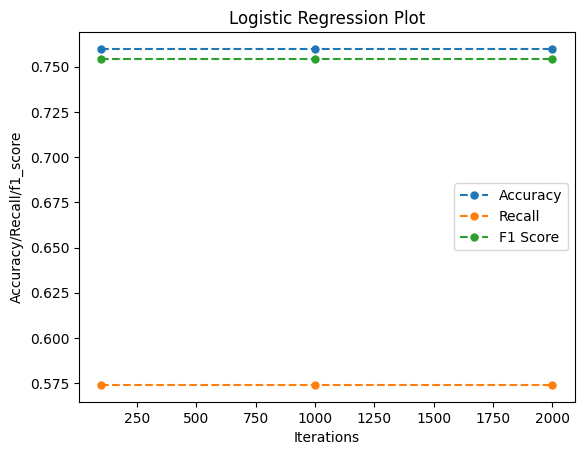

In [ ]:
accuracies = []
recalls = []
f1_scores = []
for iter in max_iter:
  model = LogisticRegression(max_iter=iter)
  model.fit(X_train, y_train.flatten())
  logisticregacc = model.score(X_test, y_test)
  y_pred = model.predict(X_test)
  recall = recall_score(y_test, y_pred)
  score = f1_score(y_test, y_pred, average='weighted')
  print(f'f1 score - : {score:.3f}')
  print(f'recall - : {recall:.3f}')
  print(f'accuracy - : {logisticregacc:.3f}')
  accuracies.append(logisticregacc)
  recalls.append(recall)
  f1_scores.append(score)

plt.plot(max_iter, accuracies, 'o', label='Accuracy', markersize=5, linestyle="--")
plt.plot(max_iter, recalls, 'o', label='Recall', markersize=5, linestyle="--")
plt.plot(max_iter, f1_scores, 'o', label='F1 Score', markersize=5, linestyle="--")
plt.title("Logistic Regression Plot")
plt.xlabel("Iterations")
plt.ylabel("Accuracy/Recall/f1_score")
plt.legend()
plt.show()

We can try further Fine tuning our model by doing some feature <br>reduction using LDA (Linear Discriminant Analysis) on our completed data

In [ ]:
completedData = np.loadtxt('./diabetes_data/raw/complete_data.csv', delimiter=',')
classMeanData = np.loadtxt('./diabetes_data/raw/class_mean_completed.csv', delimiter=',')
finalData = np.vstack((completedData, classMeanData))
np.random.shuffle(finalData)
features2 = finalData[:, :8]
classification2 = finalData[:, 8]
X_train, X_test, y_train, y_test = train_test_split(features2, classification2, test_size=0.2, random_state=42)

f1 score - : 0.782
recall - : 0.615
accuracy - : 0.786
f1 score - : 0.782
recall - : 0.615
accuracy - : 0.786
f1 score - : 0.782
recall - : 0.615
accuracy - : 0.786


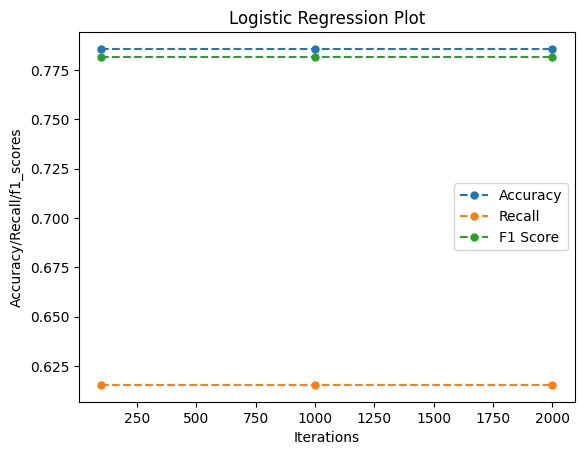

In [ ]:
#Since feature reduction techniques assume each input variable has the
#same variance, it is important to standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lda = LinearDiscriminantAnalysis(n_components=1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

accuracies = []
recalls = []
f1_scores = []
for iter in max_iter:
  model = LogisticRegression()
  model.fit(X_train_lda, y_train)
  logisticregacc = model.score(X_test_lda, y_test)
  y_pred = model.predict(X_test_lda)
  recall = recall_score(y_test, y_pred)
  score = f1_score(y_test, y_pred, average='weighted')
  print(f'f1 score - : {score:.3f}')
  print(f'recall - : {recall:.3f}')
  print(f'accuracy - : {logisticregacc:.3f}')
  accuracies.append(logisticregacc)
  recalls.append(recall)
  f1_scores.append(score)
plt.plot(max_iter, accuracies, 'o', label='Accuracy', markersize=5, linestyle="--")
plt.plot(max_iter, recalls, 'o', label='Recall', markersize=5, linestyle="--")
plt.plot(max_iter, f1_scores, 'o', label='F1 Score', markersize=5, linestyle="--")
plt.title("Logistic Regression Plot")
plt.xlabel("Iterations")
plt.ylabel("Accuracy/Recall/f1_scores")
plt.legend()
plt.show()


f1 score - : 0.799
recall - : 0.615
accuracy - : 0.805
f1 score - : 0.799
recall - : 0.615
accuracy - : 0.805
f1 score - : 0.799
recall - : 0.615
accuracy - : 0.805


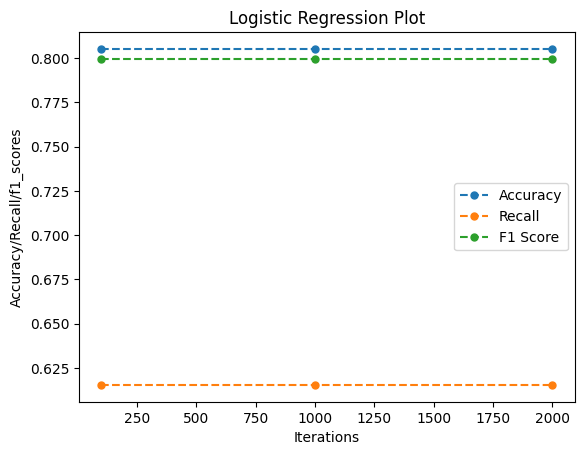

In [ ]:
accuracies = []
recalls = []
f1_scores = []
for iter in max_iter:
  model = LogisticRegression(max_iter=iter, penalty="l1", solver="liblinear")
  model.fit(X_train, y_train.flatten())
  logisticregacc = model.score(X_test, y_test)
  y_pred = model.predict(X_test)
  recall = recall_score(y_test, y_pred)
  score = f1_score(y_test, y_pred, average='weighted')
  print(f'f1 score - : {score:.3f}')
  print(f'recall - : {recall:.3f}')
  print(f'accuracy - : {logisticregacc:.3f}')
  accuracies.append(logisticregacc)
  recalls.append(recall)
  f1_scores.append(score)

plt.plot(max_iter, accuracies, 'o', label='Accuracy', markersize=5, linestyle="--")
plt.plot(max_iter, recalls, 'o', label='Recall', markersize=5, linestyle="--")
plt.plot(max_iter, f1_scores, 'o', label='F1 Score', markersize=5, linestyle="--")
plt.title("Logistic Regression Plot")
plt.xlabel("Iterations")
plt.ylabel("Accuracy/Recall/f1_scores")
plt.legend()
plt.show()

Visualization of Logistic Regression

In [ ]:
#While it is hard to visualize in higher dimension, we can visualize atleast 2 features

feature_names = ['Pregnancies', 'Glucose', 'Blood Pressure', 'Skin Thickness', 'Insulin', 'BMI', 'Diabetes Pedigree Function', 'Age']

def plot_interactive(x_feature, y_feature):
  x_index = feature_names.index(x_feature)
  y_index = feature_names.index(y_feature)

  sns.regplot(x=features[x_index], y=features[y_index], data=features, logistic=True)

  plt.title(f'Logistic Regression Plot of {x_feature} vs {y_feature}')
  plt.xlabel(x_feature)
  plt.ylabel(y_feature)
  plt.show()


x_dropdown = Dropdown(options=feature_names, value=feature_names[0], description='X-axis:')
y_dropdown = Dropdown(options=feature_names, value=feature_names[1], description='Y-axis:')

interact(plot_interactive, x_feature=x_dropdown, y_feature=y_dropdown)

# Insulin level
#x = features[4]

# BMI
#y = features[5]
#sns.regplot(x=x, y=y, data=features, logistic=True)
#plt.title('Logitstic Regression of Insulin level vs BMI')
#plt.xlabel('Insulin Level')
#plt.ylabel('BMI')
#plt.show()

interactive(children=(Dropdown(description='X-axis:', options=('Pregnancies', 'Glucose', 'Blood Pressure', 'Sk…

<function __main__.plot_interactive(x_feature, y_feature)>

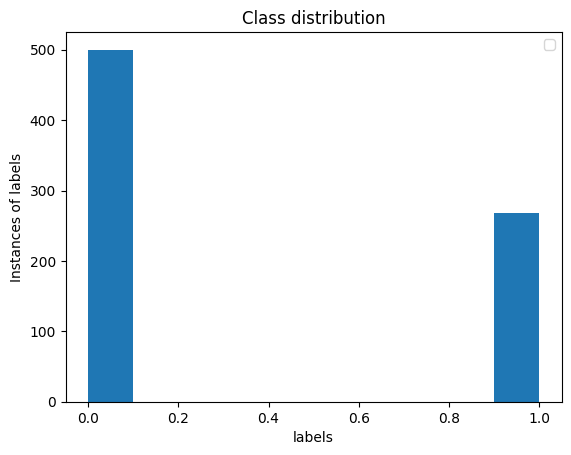

In [ ]:
pds_data = pds.read_csv(file)
data = pds_data.to_numpy()
classes = data[:, 8]
plt.hist(classes)
plt.title("Class distribution")
plt.xlabel("labels")
plt.ylabel("Instances of labels")
plt.legend()
plt.show()


## Unstructured EM (Gaussian Mixture Model) Semisupervised Approach

In [ ]:
class Semisupervised(object):
  def __init__(self, X_labeled, X_unlabeled, Y_labeled, max_iters=100):
    self.X_labeled = X_labeled
    self.X_unlabeled = X_unlabeled
    self.Y_labeled = Y_labeled

    self.N_l = X_labeled.shape[0]
    self.N_u = X_unlabeled.shape[0]
    self.D = X_labeled.shape[1]
    self.max_iters = max_iters

  def create_pi(self):
    pi1 = np.sum(self.Y_labeled) / self.Y_labeled.shape[0]
    return np.array([1-pi1, pi1])

  def create_mu(self):
    mu0 = np.mean(self.X_labeled[self.Y_labeled==0], axis=0)
    mu1 = np.mean(self.X_labeled[self.Y_labeled==1], axis=0)
    return np.array([mu0, mu1])
  def create_sigma(self):
    x0 = self.X_labeled[self.Y_labeled==0]
    x1 = self.X_labeled[self.Y_labeled==1]
    m0 = np.mean(x0, axis=0)
    m1 = np.mean(x1, axis=0)
    res0 = x0-m0
    res1 = x1-m1
    sigma0 = np.matmul(res0.T, res0)
    sigma1 = np.matmul(res1.T, res1)
    return np.array([sigma0, sigma1]) / (self.N_l-1)

  def init_components(self):
    return self.create_pi(), self.create_mu(), self.create_sigma()

  def post_class_dist(self, points, pi, mu, sigma, c):
    return pi[c]*multivariate_normal.pdf(points, mean=mu[c], cov=sigma[c], allow_singular=True) / (pi[c]*multivariate_normal.pdf(points, mean=mu[c], cov=sigma[c], allow_singular=True) + pi[1-c]*multivariate_normal.pdf(points, mean=mu[1-c], cov=sigma[1-c], allow_singular=True))

  def m_step(self, gamma0, gamma1):
    pi1 = (np.sum(gamma1) + np.sum(self.Y_labeled)) / (self.N_u + self.N_l)
    pi0 = 1 - pi1

    mu0 = (np.sum(gamma0.reshape(self.N_u, 1)*self.X_unlabeled, axis=0) + np.sum(self.X_labeled[self.Y_labeled==0], axis=0)) / (np.sum(gamma0) + np.sum(self.Y_labeled==0))
    mu1 = (np.sum(gamma1.reshape(self.N_u, 1)*self.X_unlabeled, axis=0) + np.sum(self.X_labeled[self.Y_labeled==1], axis=0)) / (np.sum(gamma1) + np.sum(self.Y_labeled))

    residual0 = (self.X_unlabeled - mu0).reshape(self.N_u, self.D, 1)
    residual0T = residual0.transpose(0,2,1)
    softweights0 = np.sum(gamma0.reshape(self.N_u, 1, 1) * np.matmul(residual0, residual0T), axis=0)
    residual0 = (self.X_labeled - mu0).reshape(self.N_l, self.D, 1)
    residual0T = residual0.transpose(0,2,1)
    sigma0 = (softweights0 + np.sum(np.matmul(residual0, residual0T)[self.Y_labeled==0], axis=0)) / (np.sum(gamma0) + np.sum(self.Y_labeled==0))

    residual1 = (self.X_unlabeled - mu1).reshape(self.N_u, self.D, 1)
    residual1T = residual1.transpose(0,2,1)
    softweights1 = np.sum(gamma1.reshape(self.N_u, 1, 1) * np.matmul(residual1, residual1T), axis=0)
    residual1 = (self.X_labeled - mu1).reshape(self.N_l, self.D, 1)
    residual1T = residual1.transpose(0,2,1)
    sigma1 = (softweights0 + np.sum(np.matmul(residual0, residual0T)[self.Y_labeled==1], axis=0)) / (np.sum(gamma0) + np.sum(self.Y_labeled))

    return np.array([pi0, pi1]), np.array([mu0, mu1]), np.array([sigma0, sigma1])

  def train(self, param_convergence=1e-10):
      pi, mu, sigma = self.init_components()
      for i in range(self.max_iters):
        gamma0 = self.post_class_dist(self.X_unlabeled, pi, mu, sigma, 0)
        gamma1 = self.post_class_dist(self.X_unlabeled, pi, mu, sigma, 1)

        pi_n, mu_n, sigma_n = self.m_step(gamma0, gamma1)
        if (np.abs(pi_n[0]-pi[0]) <= param_convergence) and (np.sum(np.abs(mu_n-mu))/self.D <= param_convergence) and (np.sum(np.abs(sigma_n-sigma))/(self.D**2) <= param_convergence):
          break
        pi = pi_n
        mu = mu_n
        sigma = sigma_n
      print(i)
      return np.array([gamma0, gamma1]), pi_n, mu_n, sigma_n

  def test(self, pi, mu, sigma, test_X, test_Y):
    gamma0 = self.post_class_dist(test_X, pi, mu, sigma, 0)
    gamma1 = self.post_class_dist(test_X, pi, mu, sigma, 1)

    label_guess = gamma1 > gamma0

    incorrect = np.sum(np.abs(label_guess - test_Y))

    TP = np.sum((test_Y+label_guess==2))
    FN = np.sum(np.logical_and(label_guess == 0, test_Y == 1))

    print("Accuracy: ", (len(test_Y)-incorrect)/len(test_Y))
    print("Recall: ", TP/(TP+FN))

  def temp_test(self, pi, mu, sigma, test_X, test_Y):
    gamma0 = self.post_class_dist(test_X, pi, mu, sigma, 0)
    gamma1 = self.post_class_dist(test_X, pi, mu, sigma, 1)

    label_guess = gamma1 > gamma0

    incorrect = np.sum(np.abs(label_guess - test_Y))

    TP = np.sum((test_Y+label_guess==2))
    FN = np.sum(np.logical_and(label_guess == 0, test_Y == 1))
    accuracy = (len(test_Y)-incorrect)/len(test_Y)
    recall = TP/(TP+FN)
    return accuracy, recall

In [ ]:
features = data[:, :8]
classification = data[:, 8]
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(features, classification, test_size=0.5, random_state=42)

EM_Model = Semisupervised(X_labeled, X_unlabeled, y_labeled)

In [ ]:
gamma, pi, mu, sigma = EM_Model.train()

In [ ]:
EM_Model.test(pi, mu, sigma, X_unlabeled, y_unlabeled)

In [ ]:
print(mu)

In [ ]:
features2 = completedData[:,:8]
classification2 = completedData[:, 8]
X_train, X_test, y_train, y_test = train_test_split(features2, classification2, test_size=0.5, random_state=1984)

In [ ]:
EM_Model2 = Semisupervised(X_train, X_test, y_train)
gamma2, pi2, mu2, sigma2 = EM_Model2.train()
EM_Model2.test(pi2, mu2, sigma2, X_test, y_test)

72
Accuracy:  0.8112244897959183
Recall:  0.7741935483870968


In [ ]:
print(mu2)

15
20
28
48
72
99
99
99
48


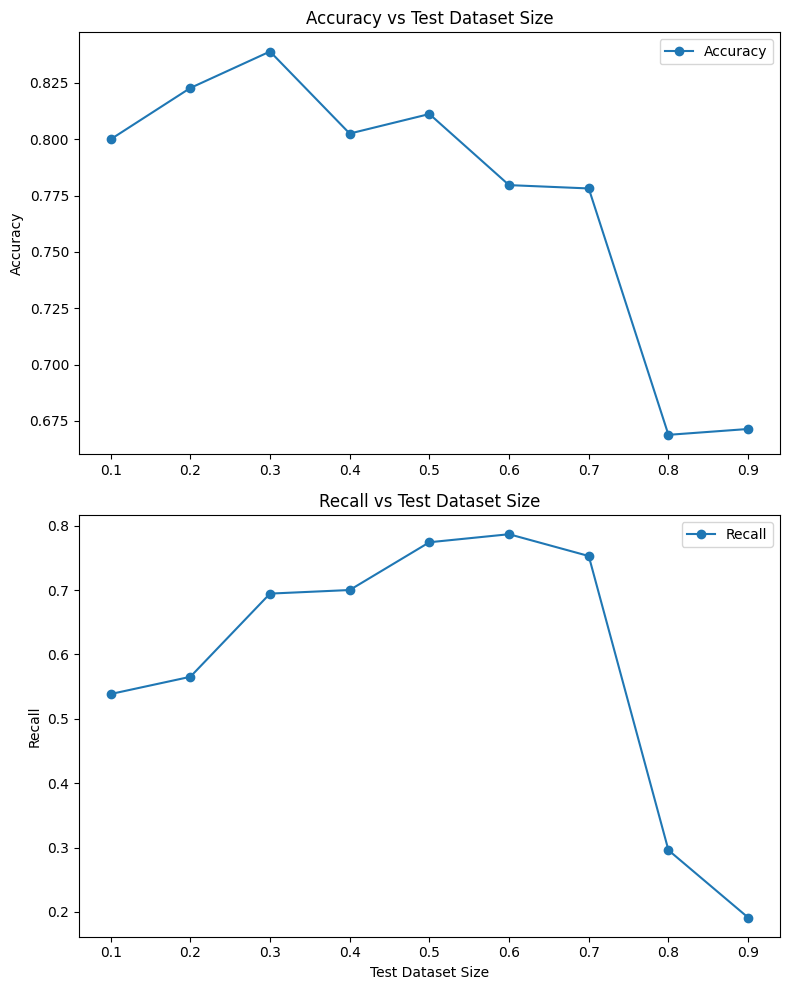

In [ ]:
def plot_and_save_accuracy(sizes, accuracies:
    plt.figure(figsize=(8, 5))
    plt.plot(sizes, accuracies, label='Accuracy', marker='o')
    plt.xlabel('Training Dataset Size')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Training Dataset Size')
    plt.legend()
    plt.show()

def plot_and_save_recall(sizes, recalls, save_path):
    plt.figure(figsize=(8, 5))
    plt.plot(sizes, recalls, label='Recall', marker='o')
    plt.xlabel('Training Dataset Size')
    plt.ylabel('Recall')
    plt.title('Recall vs Training Dataset Size')
    plt.legend()
    plt.show()

sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # Different test dataset sizes
accuracies = []
recalls = []

for size in sizes:
  X_train, X_test, y_train, y_test = train_test_split(completedData[:, :8], completedData[:, 8], test_size=size, random_state=1984)
  EM_Model = Semisupervised(X_train, X_test, y_train)
  gamma, pi, mu, sigma = EM_Model.train()
  accuracy, recall = EM_Model.temp_test(pi, mu, sigma, X_test, y_test)
  accuracies.append(accuracy)
  recalls.append(recall)

# Plot the results
plot_accuracy_recall(sizes, accuracies, recalls)

## Neural Network


In [ ]:
#Setting up the data
# X = completedData[:, :8]
# y = completedData[:, 8]

completedData = np.loadtxt('./diabetes_data/raw/complete_data.csv', delimiter=',')
classMeanData = np.loadtxt('./diabetes_data/raw/class_mean_completed.csv', delimiter=',')
finalData = np.vstack((completedData, classMeanData))
X = finalData[:, :8]
y = finalData[:, 8]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
#Building the model
model = Sequential([
    Flatten(),
    Dense(512, activation='sigmoid'),
    # BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='sigmoid'),
    # BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
])

lr = 0.0001
custom_optimizer = Adam(learning_rate=lr)

model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/30
39/39 [==============================] - 2s 13ms/step - loss: 0.6528 - accuracy: 0.6889 - val_loss: 0.6166 - val_accuracy: 0.6688
Epoch 2/30
39/39 [==============================] - 0s 7ms/step - loss: 0.5779 - accuracy: 0.7345 - val_loss: 0.6182 - val_accuracy: 0.7013
Epoch 3/30
39/39 [==============================] - 0s 6ms/step - loss: 0.4932 - accuracy: 0.8062 - val_loss: 0.6137 - val_accuracy: 0.8117
Epoch 4/30
39/39 [==============================] - 0s 7ms/step - loss: 0.5109 - accuracy: 0.7785 - val_loss: 0.6005 - val_accuracy: 0.7792
Epoch 5/30
39/39 [==============================] - 0s 7ms/step - loss: 0.4954 - accuracy: 0.7622 - val_loss: 0.5793 - val_accuracy: 0.7857
Epoch 6/30
39/39 [==============================] - 0s 8ms/step - loss: 0.5071 - accuracy: 0.7818 - val_loss: 0.5503 - val_accuracy: 0.8052
Epoch 7/30
39/39 [==============================] - 0s 7ms/step - loss: 0.4534 - accuracy: 0.8062 - val_loss: 0.5416 - val_accuracy: 0.7857
Epoch 8/30
39/39 [=

In [ ]:
model.summary()

Model: "sequential_115"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_112 (Flatten)       (None, 8)                 0         
                                                                 
 dense_355 (Dense)           (None, 512)               4608      
                                                                 
 batch_normalization_106 (B  (None, 512)               2048      
 atchNormalization)                                              
                                                                 
 dropout_111 (Dropout)       (None, 512)               0         
                                                                 
 dense_356 (Dense)           (None, 256)               131328    
                                                                 
 batch_normalization_107 (B  (None, 256)               1024      
 atchNormalization)                                 

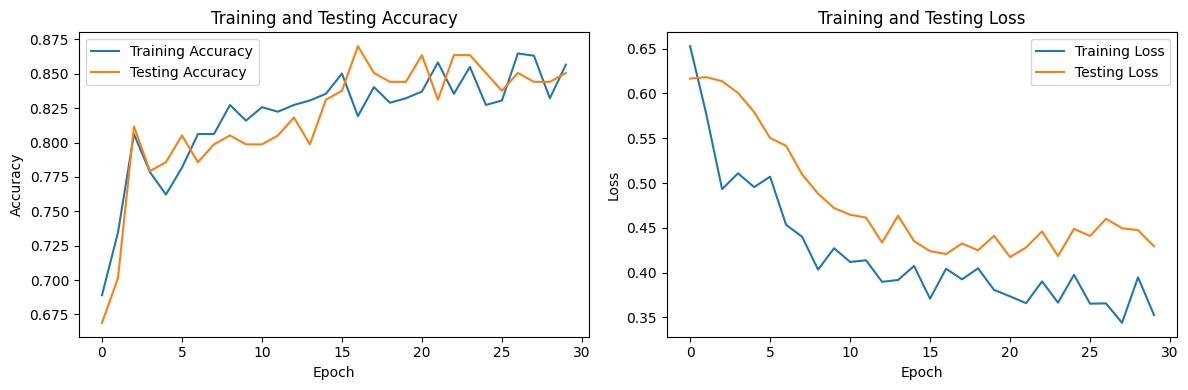

5/5 [==============================] - 0s 3ms/step
Training Recall: 0.6466
Testing Recall: 0.6688


Text(0.5, 1.0, 'Training and Testing Recall')

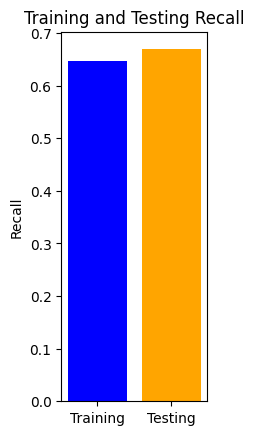

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy')

# Plot Training and Testing Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')

plt.tight_layout()
plt.show()

# Calculate Training and Testing Recall
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_recall = recall_score(y_train, np.argmax(y_train_pred, axis=1), average='weighted')
test_recall = recall_score(y_test, np.argmax(y_test_pred, axis=1), average='weighted')

print(f'Training Recall: {train_recall:.4f}')
print(f'Testing Recall: {test_recall:.4f}')

plt.subplot(1, 3, 3)
plt.bar(['Training', 'Testing'], [train_recall, test_recall], color=['blue', 'orange'])
plt.ylabel('Recall')
plt.title('Training and Testing Recall')